In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
stop_words = set(stopwords.words('english'))

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv('/kaggle/input/twitter-hate-speech/train_E6oV3lV.csv')

df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [5]:
def data_processing(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"https\S+|www\S+http\S+", '', tweet, flags = re.MULTILINE)
    tweet = re.sub(r'\@w+|\#', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r'ð', '', tweet)
    tweet_tokens = word_tokenize(tweet)
    filtered_tweets = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_tweets)

In [6]:
df.tweet = df['tweet'].apply(data_processing)
df = df.drop_duplicates('tweet')

lemmatizer = WordNetLemmatizer()
def lemmatizing(data):
    tweet = [lemmatizer.lemmatize(word) for word in data]
    return data

df['tweet'] = df['tweet'].apply(lambda x: lemmatizing(x))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29345 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      29345 non-null  int64 
 1   label   29345 non-null  int64 
 2   tweet   29345 non-null  object
dtypes: int64(2), object(1)
memory usage: 917.0+ KB


In [8]:
df['label'].value_counts()

label
0    27352
1     1993
Name: count, dtype: int64

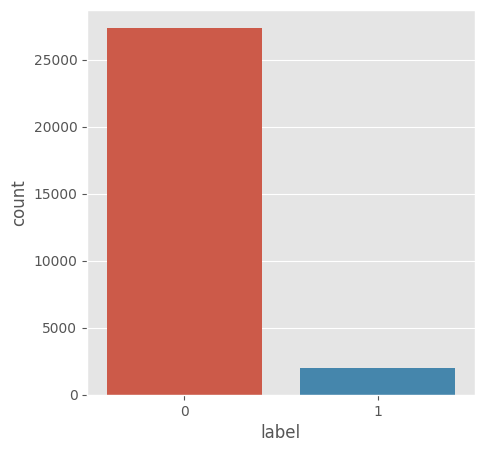

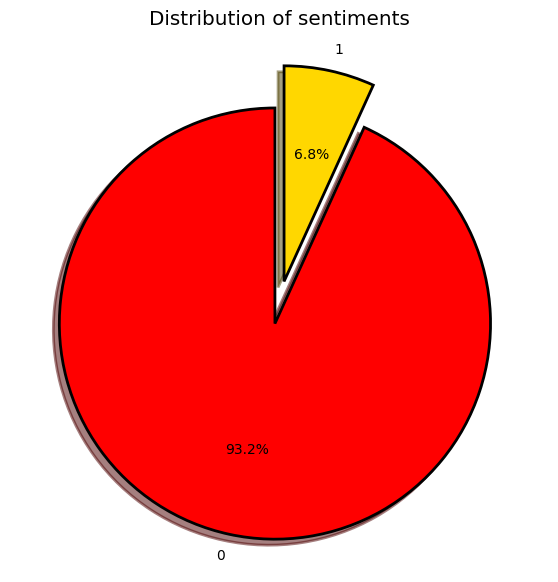

In [9]:
fig = plt.figure(figsize= (5, 5))
sns.countplot(x= 'label', data= df)

fig = plt.figure(figsize= (7, 7))
colors = ('red', 'gold')
wp = {'linewidth': 2, 'edgecolor': 'black'}
tags = df['label'].value_counts()
explode = (0.1, 0.1)

tags.plot(kind= 'pie', autopct= '%1.1f%%', shadow= True, colors= colors, startangle= 90, wedgeprops = wp, explode= explode, label= '')

plt.title('Distribution of sentiments')
plt.show()

In [10]:
non_hate_tweets = df[df.label == 0]

non_hate_tweets.head()

,id,label,tweet
0,1,0,user father dysfunctional selfish drags kids d...
1,2,0,user user thanks lyft credit cant use cause do...
2,3,0,bihday majesty
3,4,0,model love u take u time ur
4,5,0,factsguide society motivation


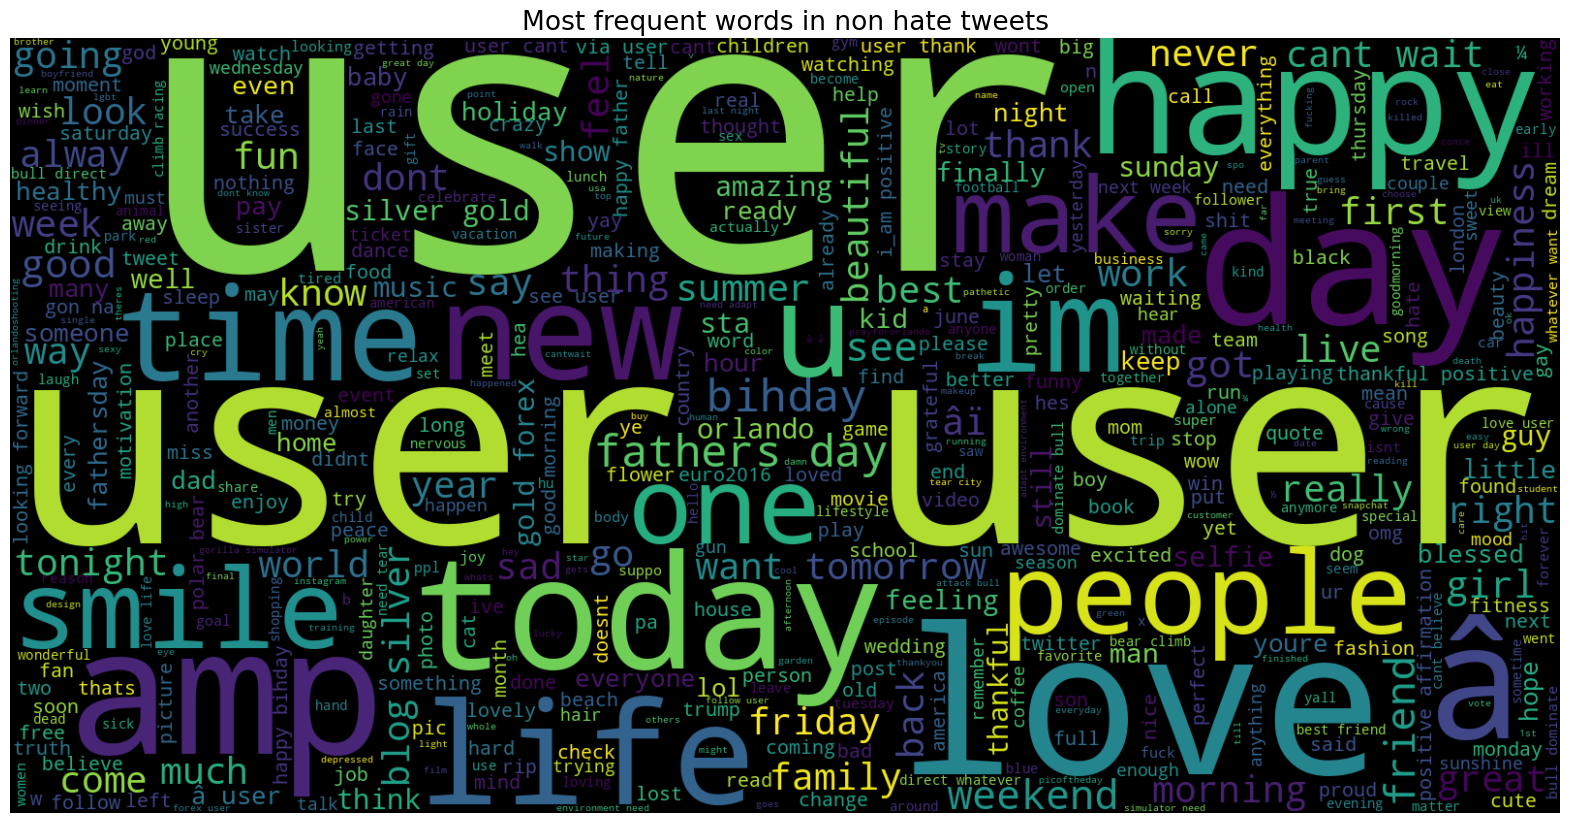

In [11]:
text = ' '.join([word for word in non_hate_tweets['tweet']])

plt.figure(figsize= (20, 15), facecolor= 'None')
wordcloud= WordCloud(max_words= 500, width= 1600, height= 800).generate(text)
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')
plt.title('Most frequent words in non hate tweets', fontsize= 19)
plt.show()

In [12]:
neg_tweets = df[df.label == 1]
neg_tweets.head()

,id,label,tweet
13,14,1,user cnn calls michigan middle school build wa...
14,15,1,comment australia opkillingbay seashepherd hel...
17,18,1,retweet agree
23,24,1,user user lumpy says prove lumpy
34,35,1,unbelievable 21st century wed need something l...


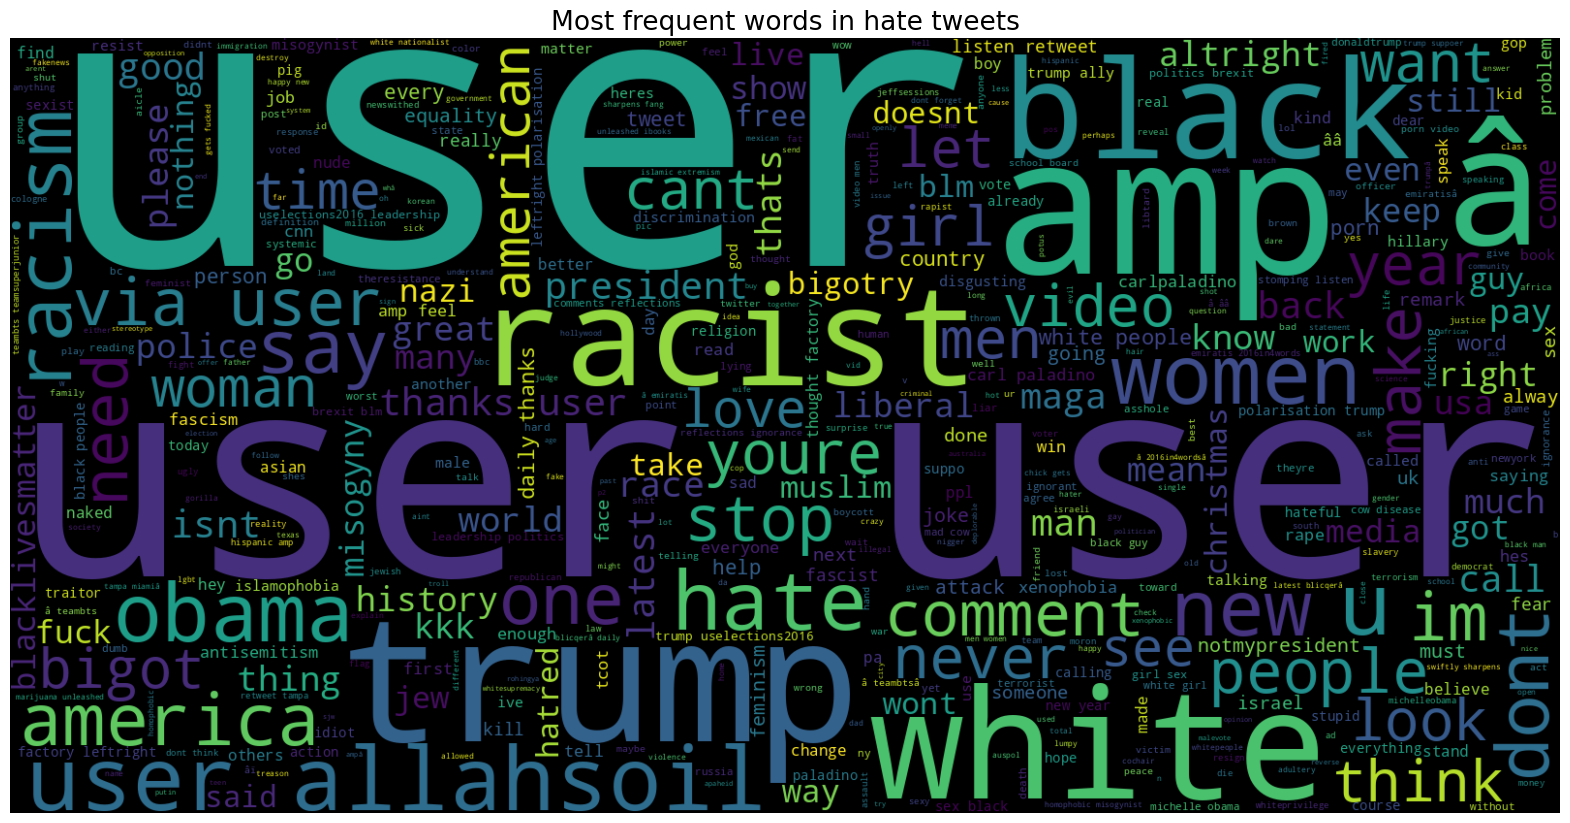

In [13]:
text = ' '.join([word for word in neg_tweets['tweet']])
plt.figure(figsize= (20, 15), facecolor= 'None')
wordcloud = WordCloud(max_words= 500, width= 1600, height= 800).generate(text)
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')
plt.title('Most frequent words in hate tweets', fontsize= 19)
plt.show()

In [14]:
vect = TfidfVectorizer(ngram_range= (1, 2)).fit(df['tweet'])
feature_names = vect.get_feature_names_out()

print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[:20]))

vect = TfidfVectorizer(ngram_range= (1, 3)).fit(df['tweet'])
feature_names = vect.get_feature_names_out()

print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[:20]))

Number of features: 208579

First 20 features: 
['0000001' '0000001 polluting' '00027' '00027 photooftheday' '001' '0035'
 '00h30' '01' '01 4995' '01 7900' '01 blog' '01 croatia' '01 may'
 '01 shopalyssas' '0115' '0115 8599968' '0161' '0161 manny' '019'
 '019 previous']
Number of features: 380305

First 20 features: 
['0000001' '0000001 polluting' '0000001 polluting niger' '00027'
 '00027 photooftheday' '00027 photooftheday music' '001' '0035' '00h30'
 '01' '01 4995' '01 4995 rustic' '01 7900' '01 7900 shopalyssas' '01 blog'
 '01 blog silver' '01 croatia' '01 croatia happy' '01 may' '01 may actual']


In [15]:
x = df['tweet']
y = df['label']
x = vect.transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

In [16]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression()

In [17]:
y_pred = lr.predict(x_test)
lr_acc = accuracy_score(y_pred, y_test)

print("Test accuracy: {:.2f}%".format(lr_acc * 100))

Test accuracy: 93.17%


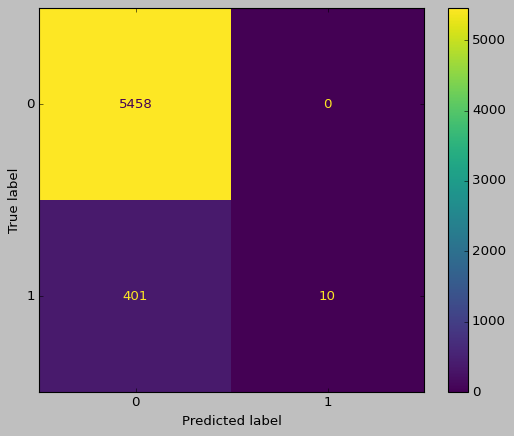

In [18]:
style.use('classic')
cm = confusion_matrix(y_test, y_pred, labels= lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= lr.classes_)
disp.plot()

In [19]:
from sklearn.model_selection import GridSearchCV

params_grid = {'C':[100, 10, 1.0, 0.1, 0.01], 'solver':['newton-cg', 'lbfgs', 'liblinear']}

grid = GridSearchCV(LogisticRegression(), params_grid, cv= 5)
grid.fit(x_train, y_train)

print("Best Cross Validation Score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

y_pred = grid.predict(x_test)
lr_acc = accuracy_score(y_pred, y_test)

print("Test accuracy: {:.2f}%".format(lr_acc * 100))
print(confusion_matrix(y_test, y_pred))
print("\n\n")

print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Cross Validation Score: 0.95
Best parameters:  {'C': 100, 'solver': 'newton-cg'}
Test accuracy: 94.89%
[[5450    8]
 [ 292  119]]



              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5458
           1       0.94      0.29      0.44       411

    accuracy                           0.95      5869
   macro avg       0.94      0.64      0.71      5869
weighted avg       0.95      0.95      0.94      5869

